In [1]:
# reload modules before executing cells
%load_ext autoreload
%autoreload 2

In [2]:

from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel

import os
import numpy as np
from PIL import Image

In [3]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
# MY_TOKEN = ''

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# model_id = "logs/dog/prior_high_lr_again"
# #model_id = "CompVis/stable-diffusion-v1-4"

# unet = UNet2DConditionModel.from_pretrained(os.path.join(model_id, "unet"))

# text_encoder = CLIPTextModel.from_pretrained(os.path.join(model_id, "text_encoder"))

model_id = "./logs/dog/prior_high_lr_again"
ldm_stable = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

/opt/conda/envs/dreambooth/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:117: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.17.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  depr

  0%|          | 0/50 [00:00<?, ?it/s]

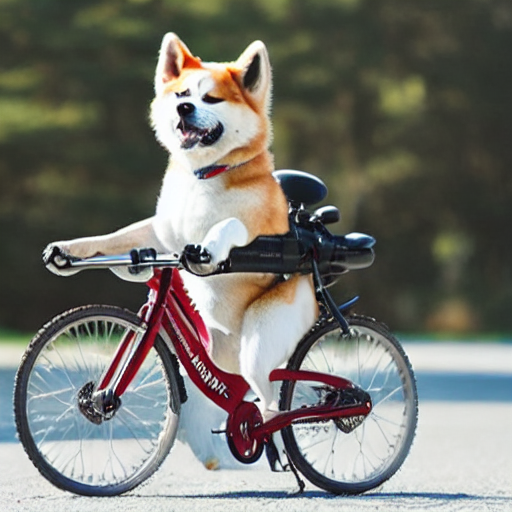

In [7]:
prompt = "photo of <sks-dog> riding a bike"

image = ldm_stable(prompt).images[0]
image

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.

## Null Text Inversion code

In [4]:
from null_inversion import NullInversion
null_inversion = NullInversion(ldm_stable, device)

/opt/conda/envs/dreambooth/lib/python3.11/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


## Infernce Code

In [6]:
image_data = "tedbench/dog/dog_with_shirt.json"

# load json
import json

with open(image_data) as f:
    data = json.load(f)
    image_path = data['image_path']
    caption = data['caption']

In [8]:
# image_path = "./example_images/gnochi_mirror.jpeg"
prompt = caption
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

Modify or remove offsets according to your image!


In [9]:
import ptp_utils
from prompt2prompt import AttentionControl, AttentionStore, make_controller
from diffusion_pipeline import run_and_display

  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image


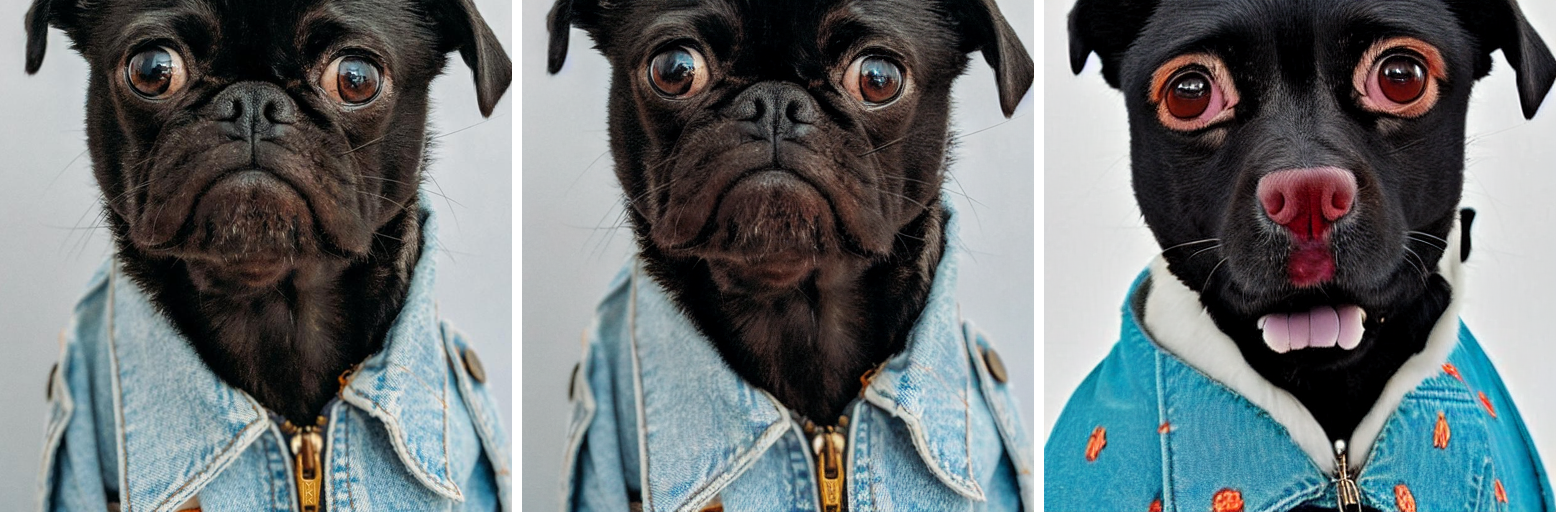

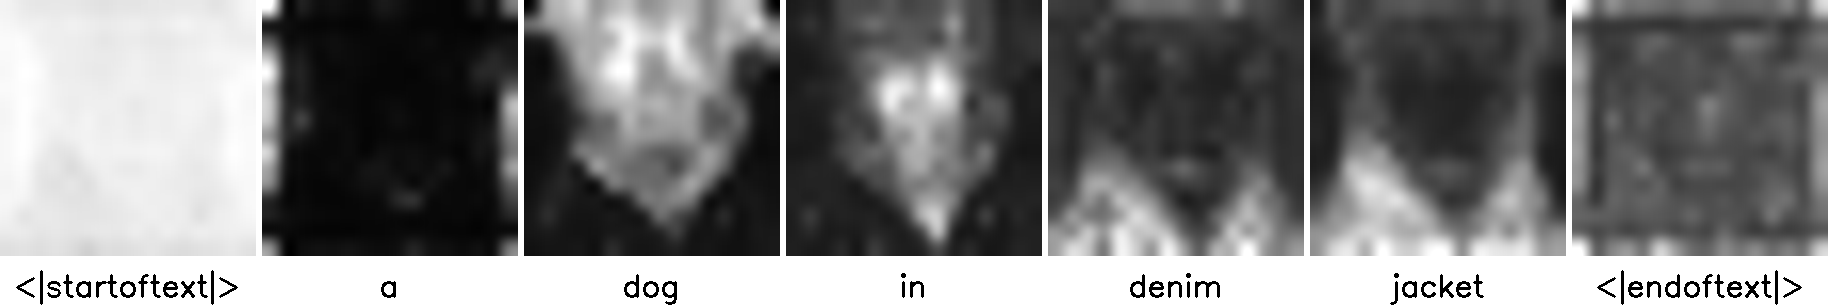

In [19]:
prompts = ["photo of a cat riding on a bicycle"]
controller = AttentionStore()
image_inv, x_t = run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=, uncond_embeddings=uncond_embeddings, verbose=False)
print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
ptp_utils.show_cross_attention(tokenizer, prompts, controller, 16, ["up", "down"])


/workspace/work/dreambooth/ptp_utils.py:126: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/50 [00:00<?, ?it/s]

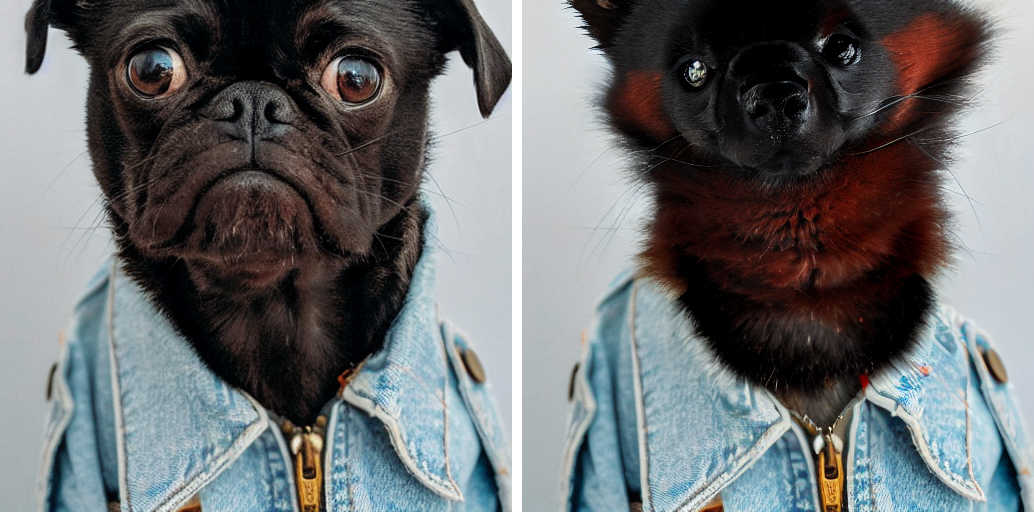

Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 


In [18]:
prompts = ["a dog wearing a denim jacket",
           "a <sks-dog> wearing a denim jacket"
        ]

cross_replace_steps = {'default_': 1.2,}
self_replace_steps = .2
blend_word = ((('dog',), ("<sks-dog> ",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("<sks-dog>",), "values": (2,)} # amplify attention to the word "tiger" by *2 

controller = make_controller( tokenizer, x_t, device, prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

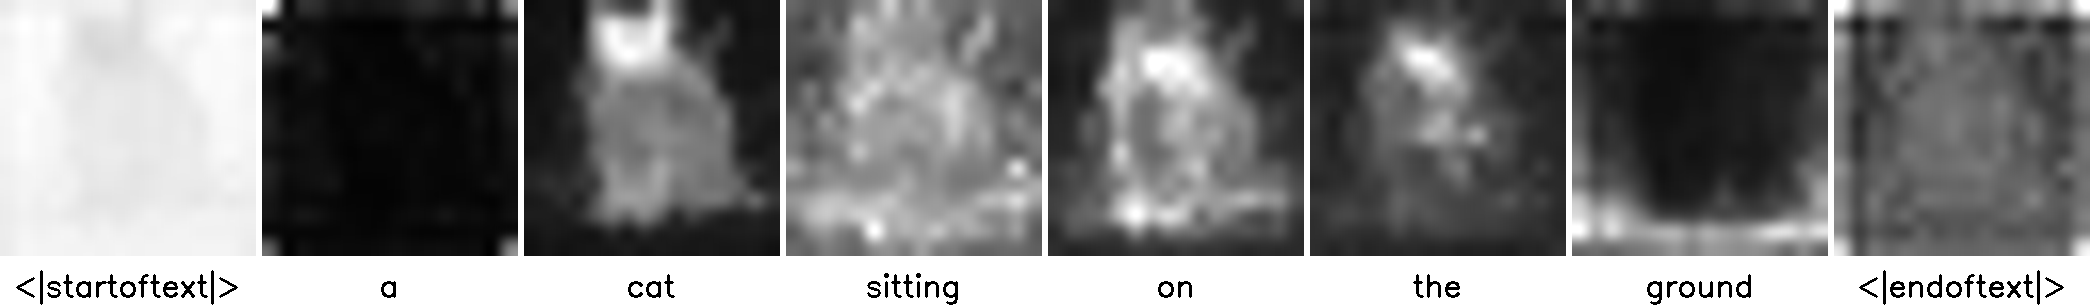

In [23]:
ptp_utils.show_cross_attention(tokenizer, prompts, controller, 16, ["up", "down"])

  0%|          | 0/50 [00:00<?, ?it/s]

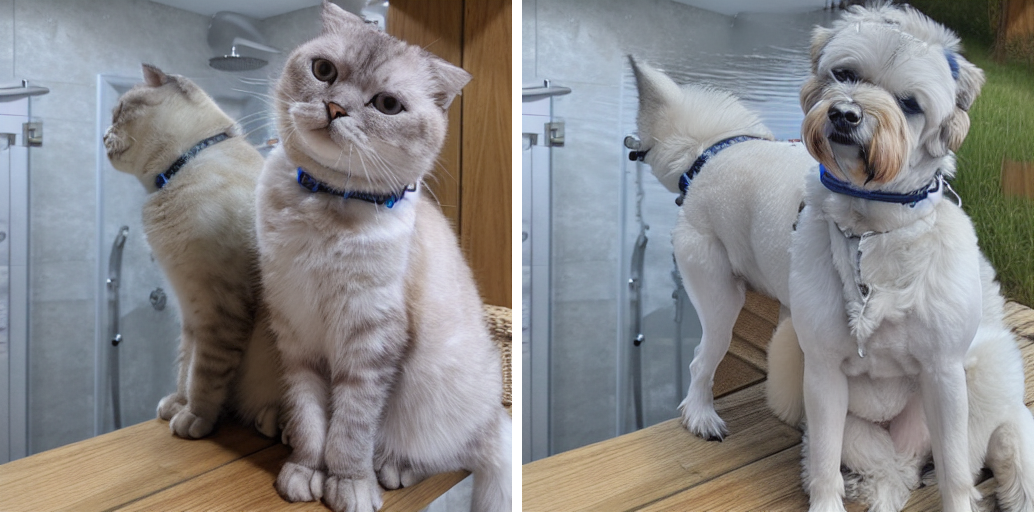

Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 


In [8]:
prompts = ["a cat sitting next to a mirror",
           "a <sks-dog> sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('cat',), ("<sks-dog> ",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("<sks-dog>",), "values": (2,)} # amplify attention to the word "tiger" by *2 

controller = make_controller( tokenizer, x_t, device, prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

  0%|          | 0/50 [00:00<?, ?it/s]

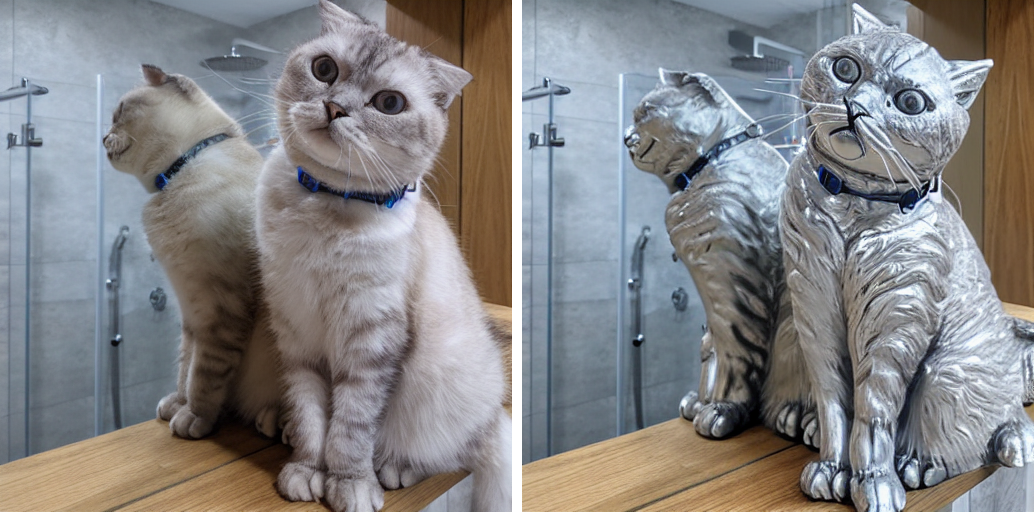

In [24]:
prompts = ["a cat sitting next to a mirror",
           "a silver cat sculpture sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .6
blend_word = ((('cat',), ("cat",))) # for local edit
eq_params = {"words": ("silver", 'sculpture', ), "values": (2,2,)}  # amplify attention to the words "silver" and "sculpture" by *2 
 
controller = make_controller( tokenizer, x_t, device, prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)


  0%|          | 0/50 [00:00<?, ?it/s]

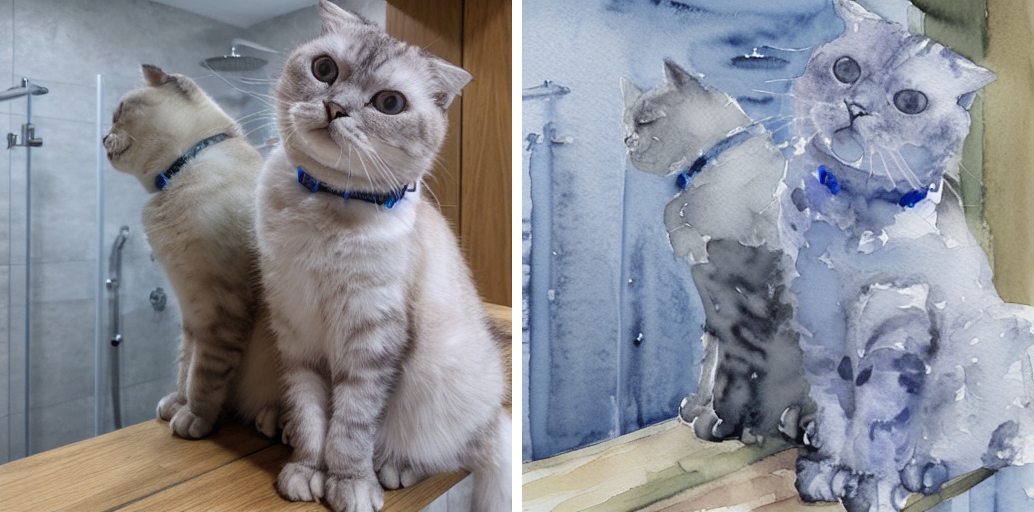

In [25]:
prompts = ["a cat sitting next to a mirror",
           "watercolor painting of a cat sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .7
blend_word = None
eq_params = {"words": ("watercolor",  ), "values": (5, 2,)}  # amplify attention to the word "watercolor" by 5
 
controller = make_controller( tokenizer, x_t, device, prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)